LSTM models
-----------

In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Optional, List, NamedTuple, Any, Tuple
from torch import Tensor

In [3]:
import data
import util
import train
import eval_

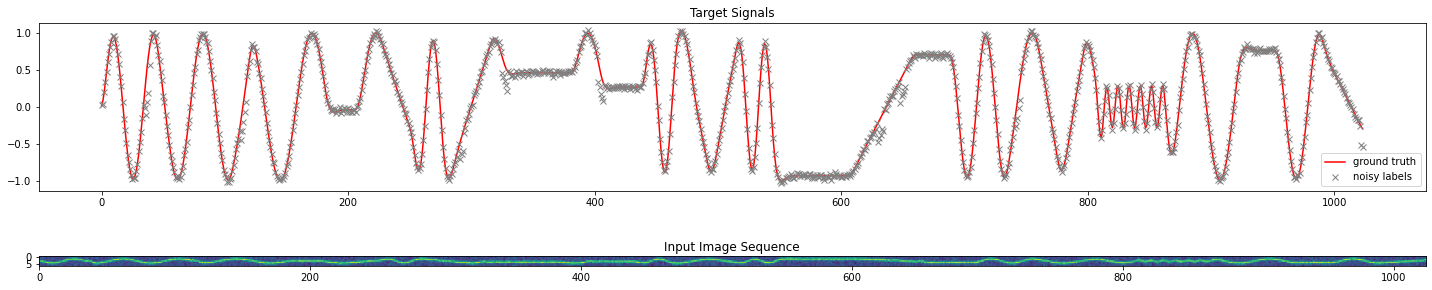

In [4]:
testdata = eval_.make_testset()

_ = data.plot_sequence(*testdata[0])
plt.tight_layout()

## Model

In [16]:
device = 'cuda'

In [17]:
from models import Backbone, Out


class LSTM(nn.Module):

    def __init__(self, hidden_size = 8, num_layers = 1):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.backbone = Backbone()
        
        self.lstm = nn.LSTM(input_size=self.backbone.num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=False)
        
        self.fc = nn.Linear(hidden_size, 1)

    @property
    def device(self):
        return next(self.parameters()).device
        
    def create_initial_state(self, batchsize):
        h_0 = torch.zeros(
            self.num_layers, batchsize, self.hidden_size, device=self.device)
        c_0 = torch.zeros(
            self.num_layers, batchsize, self.hidden_size, device=self.device)
        return (h_0, c_0)
        
    def forward(self, visuals : Tensor, lstm_state : Tuple[Tensor,Tensor]):
        h_0, c_0 = lstm_state

        z = self.backbone(util.seq_as_batch(visuals))
        z = util.batch_as_seq_like(z, visuals)

        y, (h_out, c_out) = self.lstm(z, (h_0, c_0))
               
        y = self.fc(util.seq_as_batch(y))
        y = util.batch_as_seq_like(y, visuals)
        
        return Out(y,None), (h_out, c_out)

In [27]:
def test_lstm_model():
    W = 7
    B = 9
    model = LSTM().to(device)
    model.train()
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    seqs = torch.zeros((64,B,1,W), device=device)
    out, state = model(
        seqs,
        model.create_initial_state(B)
    )
    assert out.y.shape[0] == 64

    out, state = model(seqs, model.create_initial_state(B))
    assert out.y.shape[0] == seqs.shape[0]

test_lstm_model()

Num Parameters:  3409


In [28]:
from models import SingleFrameRegression

# Note: Single frame model has at least as many parameters as recurrent model,
#       so given the infinite training data availability, it should not be limited by capacity nor
#       overfitting in comparison to the recurrent model.

def test_single_frame_regression():
    B = 42
    W = 7
    model = SingleFrameRegression().to(device)
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    seqs = torch.zeros((B,1,W), device=device)
    out = model(seqs)
    assert out.y.shape[0] == B

test_single_frame_regression()

Num Parameters:  4361


## Training

In [29]:
num_samples = 8 * 1024 * 1024
learning_rate = 0.01

## Testing

In [34]:
sfmodel = SingleFrameRegression().to(device)
train.train_singleframe_model(sfmodel, 4096, num_samples, learning_rate)

Loss: 0.00350: 100%|██████████| 2048/2048 [00:08<00:00, 238.73it/s]


In [35]:
lstm = LSTM().to(device)
train.train_sequence_model(lstm, 128, 32, num_samples, learning_rate, None, None)

Loss: 0.00294, Smoothness nan: 100%|██████████| 2048/2048 [00:10<00:00, 190.47it/s]


In [36]:
lstm_smooth_A = LSTM().to(device)
train.train_sequence_model(lstm_smooth_A, 128, 32, num_samples, learning_rate, 5., train.Smooth2ndDerivLoss().to(device))

Loss: 0.00597, Smoothness 0.00138: 100%|██████████| 2048/2048 [00:10<00:00, 186.71it/s]


In [37]:
lstm_smooth_B = LSTM().to(device)
train.train_sequence_model(lstm_smooth_B, 128, 32, num_samples, learning_rate, 5., train.RobustSmooth2ndDerivLoss(eps=0.1).to(device))

Loss: 0.00343, Smoothness 0.00012: 100%|██████████| 2048/2048 [00:11<00:00, 185.79it/s]


In [39]:
lstm_smooth_extreme = LSTM().to(device)
train.train_sequence_model(lstm_smooth_extreme, 128, 32, num_samples, learning_rate, 100., train.RobustSmooth2ndDerivLoss(eps=0.01).to(device))

Loss: 0.02374, Smoothness 0.00015: 100%|██████████| 2048/2048 [00:11<00:00, 180.52it/s]


sfmodel


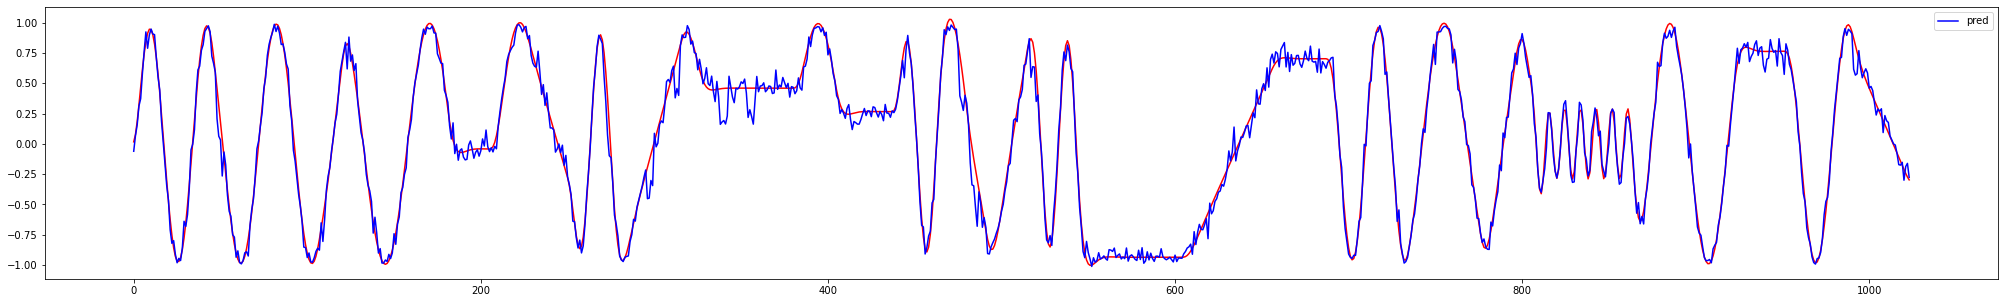

lstm model


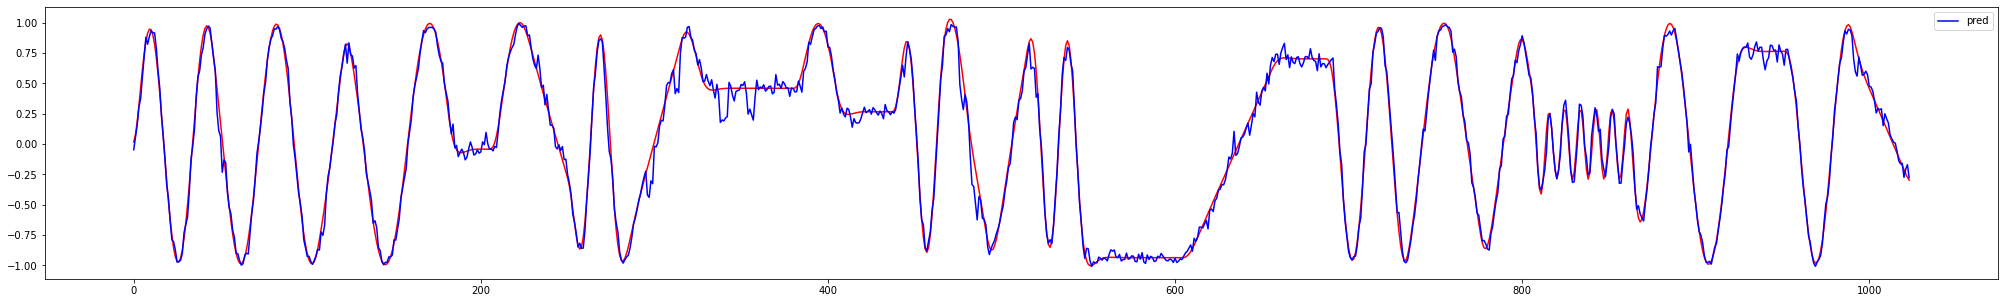

lstm_smooth_A


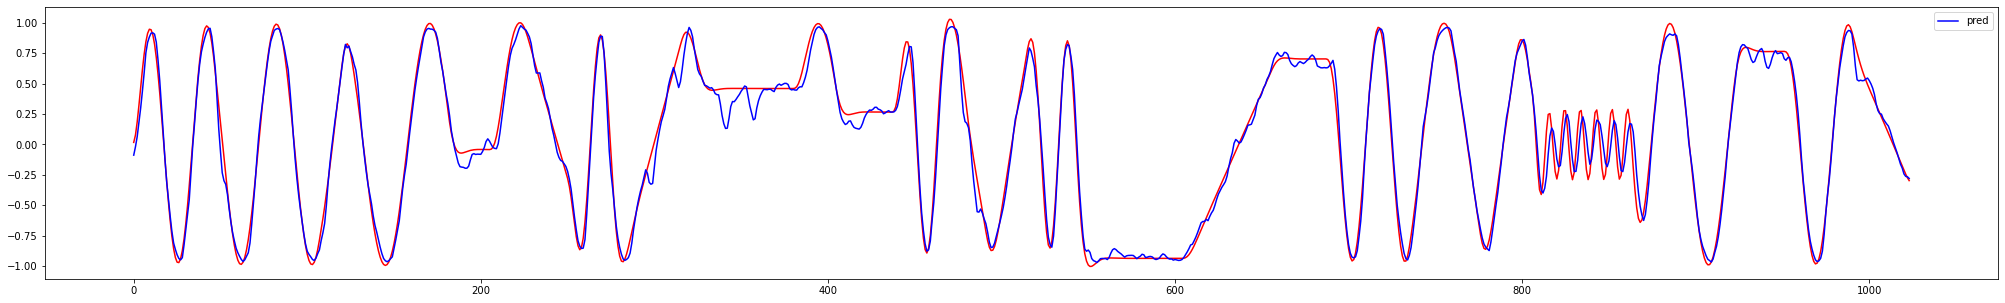

lstm_smooth_B


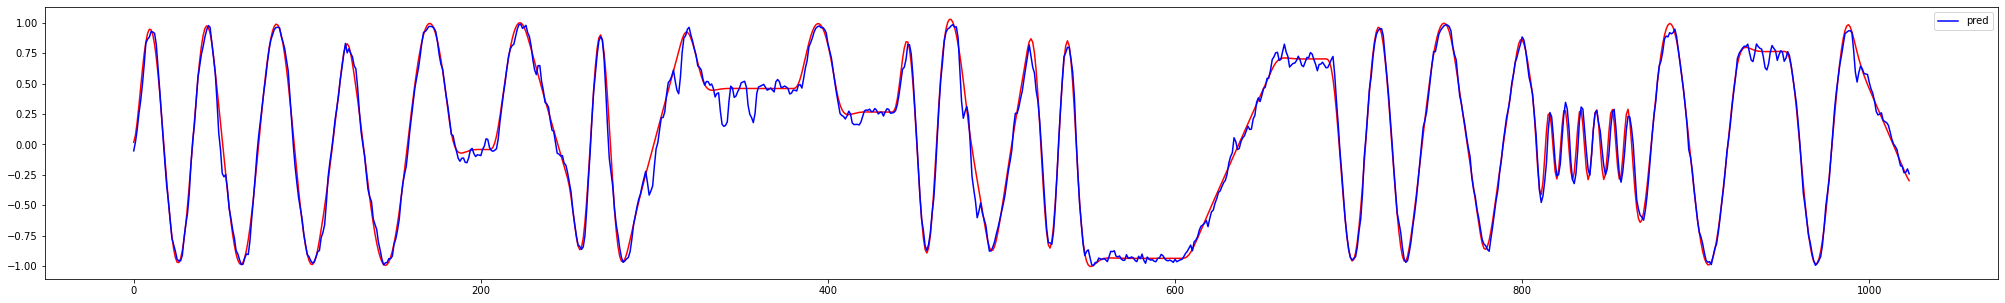

lstm_smooth_extreme


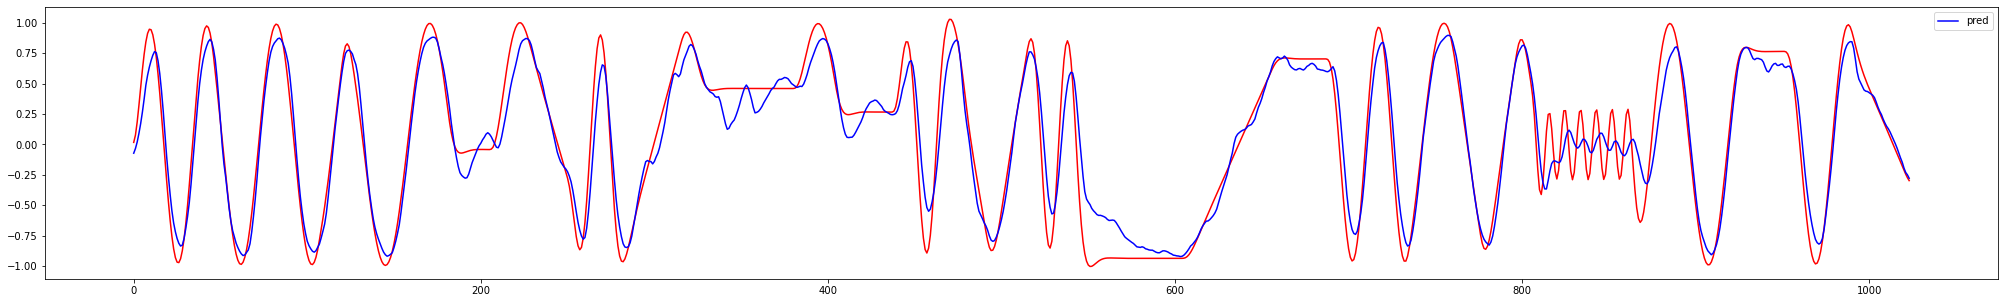

In [40]:
print('sfmodel'); eval_.evaluate(sfmodel, testdata)
print('lstm model'); eval_.evaluate(lstm, testdata)
print('lstm_smooth_A'); eval_.evaluate(lstm_smooth_A, testdata)
print('lstm_smooth_B'); eval_.evaluate(lstm_smooth_B, testdata)
print('lstm_smooth_extreme'); eval_.evaluate(lstm_smooth_extreme, testdata)